In [67]:
import copy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# class SNP500():
#     def __init__(self):
#         self.retrieve()
    
#     def retrieve(self, ticker='^GSPC', intv='1m'):
#         self.df = yf.download(ticker, interval=intv)

#     def bipower_variance(self, r: list[float], K=390) -> float:
#         a = np.abs(r[::-1][: K])
#         b = np.abs(r[::-1][1: K+1])
        
#         return np.pi / (2 * K) * np.sum(a * b)

#     def local_volatility(self, r: list[float], K=390) -> float:
#         return np.sqrt(self.bipower_variance(r, K))

We first load S&P 500 data (1m) for past 30 days. Then we add the 1-min return, which is defined as 

$$r_t = \log_{10}(p_t / p_{t-1})$$ 

where $p_t$ is the price at $t$. On the other hand, the rolling volatility is measured by the following bipower variance:

$$
\sigma_t^2 = \frac{\pi}{2K} \sum_{i=1}^K | r_{t-i} | | r_{t-i+1} |
$$

where $K=390$. Note that one day contains $K=390$ of 1-min data, and hence, the above volatility estimate is based on a day of S&P500 data. For the definition and explanation, see https://arxiv.org/pdf/2106.07040 and references therein.

In [212]:
def collect_data(intv='1m', ticker='^GSPC'):
    '''
    Collect intv data for past 30 days
    Input
        intv    (str)   interval
        ticker  (str)   ticker
    '''
    t0 = datetime.datetime.today() - datetime.timedelta(days=29)
    start_date = [t0 + datetime.timedelta(days=5 * i) for i in range(6)]
    
    market_data = pd.concat([yf.download(ticker, 
                                         start=sd.strftime('%Y-%m-%d'), 
                                         end=(sd + datetime.timedelta(days=4)).strftime('%Y-%m-%d'),
                                         interval=intv) 
                                         for sd in start_date],
                            sort=True)
    
    market_data['Return'] = np.log(market_data['Close'] / market_data['Open'])
    market_data['Variance'] = market_data['Return'].rolling(390).apply(bipower_variance)
    market_data['Volatility'] = market_data['Return'].rolling(390).apply(local_volatility)
    market_data['Jump'] = np.abs(market_data['Return'] / market_data['Volatility'])

    return market_data
    
def bipower_variance(r: list[float], K=390) -> float:
    a = np.abs(r[::-1][: K])
    b = np.abs(r[::-1][1: K+1])
    
    return np.pi / (2 * K) * np.sum(a * b)

def local_volatility(r: list[float], K=390) -> float:
    return np.sqrt(bipower_variance(r, K))

In [213]:
market_data = collect_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


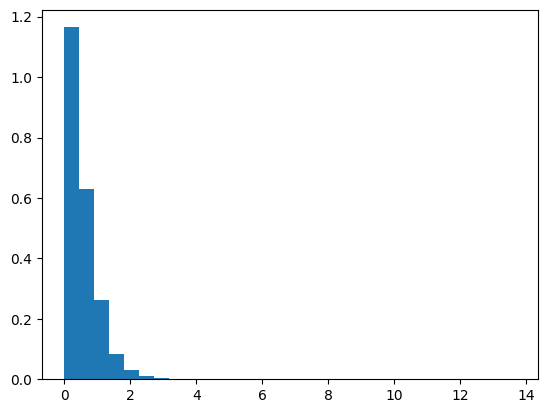

In [224]:
plt.hist(np.array(market_data['Jump']), 
         bins=30,
         density=True);

In [338]:
raw_anomalous_jump = market_data['Jump'][market_data['Jump'] > 4]

In [333]:
diff = raw_anomalous_jump.index.to_series().diff().fillna(datetime.timedelta(hours=10))
mask = (diff > datetime.timedelta(hours=1))

In [339]:
anomalous_jump = raw_anomalous_jump[mask]
jump_time = anomalous_jump.index

In [340]:
jump_series = []

for jp in jump_time:
    if jp.time() > datetime.time(14, 30) and jp.time() < datetime.time(19, 0):
        print(jp, anomalous_jump[jp])
        jump_series.append(market_data[(market_data.index > jp + datetime.timedelta(hours=-1)) & (market_data.index < jp + datetime.timedelta(hours=1))]['Jump'])

2025-04-08 18:30:00+00:00 4.789253659292076
2025-04-09 17:18:00+00:00 4.2860741358390175
2025-04-16 17:31:00+00:00 5.049809049590347
2025-04-22 15:59:00+00:00 4.279117255860215


4.789253659292076
13.668970782316572
5.049809049590347
5.1840208307412725


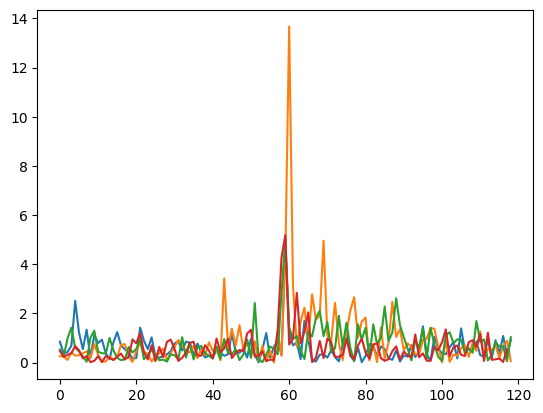

In [341]:
for i in range(len(jump_series)):
    print(max(jump_series[i]))
    plt.plot(np.array(jump_series[i]))

Jumps; we discard jumps that took place within 60 min after market open or 60 min before market close. In addition, some jumps are associated with multiple jumps within +- 2 hours, e.g. orange. We only count initial jump. 

In [342]:
raw_anomalous_jump

Datetime
2025-04-08 18:30:00+00:00     4.789254
2025-04-08 19:50:00+00:00     4.101559
2025-04-09 17:18:00+00:00     4.286074
2025-04-09 17:19:00+00:00    13.668971
2025-04-09 17:28:00+00:00     4.952403
2025-04-16 17:31:00+00:00     5.049809
2025-04-22 15:59:00+00:00     4.279117
2025-04-22 16:00:00+00:00     5.184021
2025-04-23 13:30:00+00:00     6.602027
2025-04-23 13:37:00+00:00     9.828479
2025-05-01 19:50:00+00:00     4.326865
2025-05-02 13:30:00+00:00     5.232219
Name: Jump, dtype: float64